# Spatio-Temporal Event Prediction Project
## Prepared by Furkan Küçük for DataBoss Analytics Job Application

Spatio-Temporal prediction became as an important research topic for the field of Deep Learning applications. It may have wide applications for Video processing, sequential image processing and event prediction. 

This notebook will focus on the models designed for Spatio-Temporal event prediction.

In [12]:
from torch.utils.data import DataLoader
from model_utils import ModelEngine
import numpy as np
import torch
from torch import nn, optim

from CNN_RNN import CNNwithRNN
from CRNN import CRNN
from ConvNet import ConvNet
from utils import train_test_split
from DatasetUtils import *
from evaluation_utils import calculate_f1_score_for_thresholds
import matplotlib.pyplot as plt
# Disabling warnings. This should be used with great caution as this might be suppress neccessary warnings.
import warnings
warnings.filterwarnings("ignore")

In this project, we have minimal information about the given dataset. However, one may develop some intuition with applying various machine learning models and evaluating them. 

In [2]:
dataset = np.load("data/train_set.npy")
trainset, testset = train_test_split(dataset)
train_dataset, validation_dataset = train_test_split(dataset=trainset, train_set_ratio=1 - (len(testset) / len(trainset)))

This network architecture type is first to be experimented on. The model architecture is as follows:

- Transposed Convolution Layers employed as adaptive up-sampling. Intuition behind this step is simply finding a regression pattern between adjacent places.
- Convolutional Layers employed for enriched pattern detection between previously found regression patterns. Both Transposed Convolutional and standard Convolutional layers are employed to capture spatial data.
- GRU Layer employed to capture temporal data. Please note that some important spatial data might be lost due to transition from spatial feature extractor part of the model (previous layer).
- Fully connected layer for decision making.

In [3]:
model1 = CNNwithRNN()
optimizer1 = optim.Adam(model1.parameters())
criterion1 = nn.BCEWithLogitsLoss()
engine1 = ModelEngine(model1, criterion1, optimizer1, is_recurrent=True, model_name="CNNwithRNN1")
train_dataset1 = CNNwithRNNDataset(train_dataset)
validation_dataset1 = CNNwithRNNDataset(validation_dataset)
dataloaders1 = {
    "train": DataLoader(train_dataset1, batch_size=32),
    "val": DataLoader(validation_dataset1, batch_size=32)
}

Using device cuda:0


In [4]:
engine1.fit(dataloaders1, retain_graph=True)

Loss diddn't decrease. Early stopping.


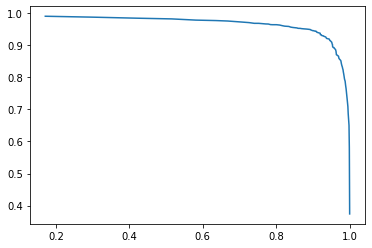

In [13]:
precision, recall = engine1.evaluate_model_with_probas(dataloaders1["val"])
plt.plot(recall, precision)
plt.show()

As we see in the figure above, the Precision-Recall curve appears to be at some acceptable level.

In [14]:
np.max(calculate_f1_score_for_thresholds(recall, precision))

0.9313640312771504

The best F1 score from the trained model is like 0.93.

2D Convolutional Networks are good for detecting robust spatial patterns. They are also translation invariant. That property enables us to detect spatial patterns from a whole matrix (in most cases, these matrices are images). One may want to take advantage of this property as treating temporal information as spatial information. Since the property of being translation invariant still holds, this experiment may enables us to have a very important intuition about the given dataset by answering an important question: Are there any patterns in dataset?

The model architecture is as follows:
- Transposed Convolution Layers employed as adaptive up-sampling. Intuition behind this step is simply finding a regression pattern between adjacent places and adjacent time steps.
- Convolutional Layers employed for enriched pattern detection between previously found regression patterns. Both Transposed Convolutional and standard Convolutional layers are employed to capture spatial and temporal patterns.
- Fully connected layer for decision making.

In [5]:
model2 = ConvNet()
criterion2 = nn.BCEWithLogitsLoss()
optimizer2 = optim.Adam(model2.parameters())
train_dataset2 = ConvNetDataset(train_dataset)
validation_dataset2 = ConvNetDataset(validation_dataset)
dataloaders2 = {
    "train": DataLoader(train_dataset2, batch_size=32),
    "val": DataLoader(validation_dataset2, batch_size=32)
}
engine2 = ModelEngine(model2, criterion2, optimizer2, model_name="3DConvNet1")

Using device cuda:0


In [6]:
engine2.fit(dataloaders2)

Loss diddn't decrease. Early stopping.


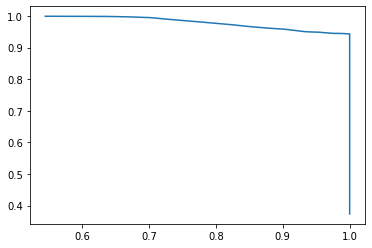

In [15]:
precision, recall = engine2.evaluate_model_with_probas(dataloaders2["val"])
plt.plot(recall, precision)
plt.show()

From Precision-Recall curve above we can infer that 3D CNN architecture performs better than CNN with GRU model. One can also infer from the performance of that model that, the dataset has learnable patterns both in Spatial and Temporal domains 

In [16]:
np.max(calculate_f1_score_for_thresholds(recall, precision))

0.970920138888889

The best F1 score from the trained model is 0.97.

3D Convolutional Networks are mainly pattern extractors. The prediction they made is somewhat similar to Bayesian inference. This means, 3D Convolutional Networks will not perform well on unseen data. Convolutional GRU Network is simply a GRU emulation using convolutional kernels. A single Convolutional GRU (GRU2D) cell consists the same gates as standard GRU cells: 
- Reset Gate: This gate is employed for how much information from past to take into account.
- Update Gate: This gate controls which information to forget, and which information to take into account.
- Out Gate: Output of the GRU cell.

In [7]:
model3 = CRNN()
optimizer3 = optim.Adam(model3.parameters())
criterion3 = nn.BCEWithLogitsLoss()
engine3 = ModelEngine(model3, criterion3, optimizer3, is_recurrent=True, model_name="CRNN1")
train_dataset3 = CRNNDataset(train_dataset)
validation_dataset3 = CRNNDataset(validation_dataset)
dataloaders3 = {
    "train": DataLoader(train_dataset3, batch_size=32),
    "val": DataLoader(validation_dataset3, batch_size=32)
}

Using device cuda:0


In [8]:
engine3.fit(dataloaders3, retain_graph=True)

Loss diddn't decrease. Early stopping.


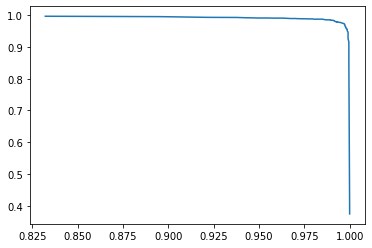

In [17]:
precision, recall = engine3.evaluate_model_with_probas(dataloaders3["val"])
plt.plot(recall, precision)
plt.show()

In [16]:
np.max(calculate_f1_score_for_thresholds(recall, precision))

0.970920138888889

Convolutional GRU (or CRNN) architecture outputs the best Precision-Recall curve among other models which means by evaluating probabilities alone, CRNN model performs the best. F1 score is the same as 3D Conv Net but validation loss is even lower. This means this model is tops for robustness.

### Evaluation on Test Dataset

It is a good practice to save a test set which is never seen before by the model, and evaluate the final results on it.

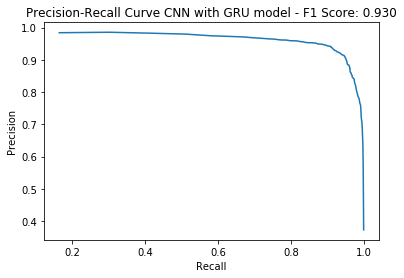

In [28]:
testset1 = CNNwithRNNDataset(testset)
dataloader_test1 = DataLoader(testset1, batch_size=32)
precision, recall = engine1.evaluate_model_with_probas(dataloader_test1)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
f1_score = np.max(calculate_f1_score_for_thresholds(recall, precision))
plt.title("Precision-Recall Curve CNN with GRU model - F1 Score: {0:.3f}".format(f1_score))
plt.show()

As it can be seen, the precision-recall curve is similar with the validation dataset. F1 score of this model is at acceptable levels.

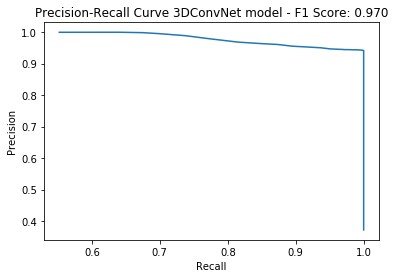

In [29]:
testset2 = ConvNetDataset(testset)
dataloader_test2 = DataLoader(testset2, batch_size=32)
precision, recall = engine2.evaluate_model_with_probas(dataloader_test2)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
f1_score = np.max(calculate_f1_score_for_thresholds(recall, precision))
plt.title("Precision-Recall Curve 3DConvNet model - F1 Score: {0:.3f}".format(f1_score))
plt.show()

One may infer from the above figure, 3DCNN still outperforms the CNN with GRU structure.

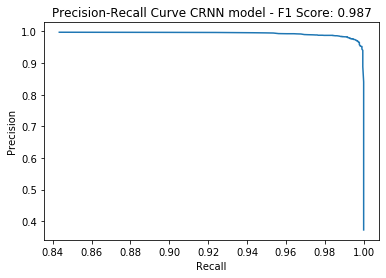

In [30]:
testset3 = CRNNDataset(testset)
dataloader_test3 = DataLoader(testset3, batch_size=32)
precision, recall = engine3.evaluate_model_with_probas(dataloader_test3)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
f1_score = np.max(calculate_f1_score_for_thresholds(recall, precision))
plt.title("Precision-Recall Curve CRNN model - F1 Score: {0:.3f}".format(f1_score))
plt.show()

As expected, the precision-recall curve for CRNN model appears to be best among other models. For the test set, best F1 score surpassed 3DConvNet's score.